# Burglar

In [1]:
import numpy as np
import sys
from brml.variable import variable
from brml.potential import potential
from brml.multpots import multpots
from brml.potvariables import potvariables
from brml.setpot import setpot
from brml.condpot import condpot
from brml.dag import dag
import networkx as nx

%matplotlib inline

PotentialClass is imported as module
VariableClass is imported as module


In [11]:
#!/usr/bin/env python

# Python implementation of BRMLtoolbox
# Author: Mingjun Zhou
# License: GNU License

"""
DEMOBURGLAR DEMO: was it the burglar example?
"""



burglar, earthquake, alarm, radio = list(range(4))  # Variable order is arbitary
yes = 0
no = 1

variables = [variable(None, None) for i in range(4)]

variables[burglar].name = 'burglar'
variables[burglar].domain = ['yes', 'no']

variables[earthquake].name = 'earthquake'
variables[earthquake].domain = ['yes', 'no']

variables[alarm].name = 'alarm'
variables[alarm].domain = ['yes', 'no']

variables[radio].name = 'radio'
variables[radio].domain = ['yes', 'no']

pot = [potential() for i in range(4)]

pot[burglar].variables = np.array([burglar])
pot[burglar].card = np.array([2])
table = np.zeros(2)
table[yes] = 0.01
table[no] = 0.99
pot[burglar].table = table

pot[earthquake].variables = np.array([earthquake])
pot[earthquake].card = np.array([2])
table = np.zeros(2)
table[yes] = 0.000001
table[no] = 1 - table[yes]
pot[earthquake].table = table

pot[alarm].variables = np.array([alarm, burglar, earthquake])
pot[alarm].card = np.array([2, 2, 2])
table = np.zeros((2, 2, 2))
table[yes, yes, yes] = 0.9999
table[yes, yes, no] = 0.99
table[yes, no, yes] = 0.99
table[yes, no, no] = 0.0001
table[no][:][:] = 1 - table[yes][:][:]
pot[alarm].table = table

pot[radio].variables = np.array([radio, earthquake])
pot[radio].card = np.array([2, 2])
table = np.zeros((2, 2))
table[yes, yes] = 1
table[no, yes] = 0
table[yes, no] = 0
table[no, no] = 1
pot[radio].table = table

#va = potvariables(pot)
jointpot = multpots(pot)
#print "jointpot.variables:", jointpot.variables
#print "jointpot.card:", jointpot.card
#print "jointpot.table:", jointpot.table

#print jointpot.variables
burglar_dag = dag(pot) # Generate the DAG adjacency matrix
print("DAG adjacency matrix: \n", burglar_dag)

alarm_evidencedpot = setpot(jointpot, alarm, yes)
#FIXME: arbitrary setting
#evidencedpot.variables = evidencedpot.variables[1:]
#print "................................................"
#print "evidencedpot.variables:", evidencedpot.variables
#print "evidencedpot.table: \n", evidencedpot.table

#print "evidencepot.variables:", evidencedpot.table
alarm_conditionedpot = condpot(alarm_evidencedpot, burglar)
print("p(burglar|alarm=yes)")
print("conditionedpot.variables:", alarm_conditionedpot.variables)
print("conditionedpot.table: \n", alarm_conditionedpot.table)
# jointpot = multpots(pot); % joint distribution

radio_evidencedpot = setpot(jointpot, [alarm, earthquake], [yes, yes])
radio_conditionedpot = condpot(radio_evidencedpot, burglar)
print("p(burglar|alarm=yes, radio=yes):")
print("conditionedpot.variables:", radio_conditionedpot.variables)
print("conditionedpot.table: \n", radio_conditionedpot.table)
#print "type:", (conditionedpot.table).dtype

('variables:', array([0., 1., 2., 0., 1., 3., 1.]))
('number of variables:', 4)
('empty DAG matrix: \n', array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]))
('DAG adjacency matrix: \n', array([[0., 0., 1., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]))
('current divided newpot.variables=', (array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)))
('current divided table: \n', array([[[0.99000198]],

       [[0.00999802]]]))
p(burglar|alarm=yes)
('conditionedpot.variables:', (array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)))
('conditionedpot.table: \n', array([[[0.99000198]],

       [[0.00999802]]]))
('current divided newpot.variables=', (array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)))
('current divided table: \n', array([[0.01009899],
       [0.98990101]]))
p(burglar|alarm=yes, radio=yes):
('conditionedpot.variables:', (

In [4]:
var_names = dict((i, n) for (n, i) in enumerate(["burglar", "earthquake", "alarm", "radio"]))

val_names = {"yes": yes, "no": no}

conditioning_vals = {
    "alarm": "yes",
    #"radio": "yes"
}

## TODO

Add utils for creating the DAG to simplify the setup cell

In [6]:
class DAG:
    def __init__(self, var_names, pot, val_names={"yes": 0, "no": 1}):
        self.var_names = var_names
        self.dag = dag(pot)
        self.jointpot = multpots(pot)
        self.graph = DAG.make_nx_graph(self.dag, var_names)
        self.val_names = val_names

    @staticmethod
    def make_nx_graph(adjacency_matrix, node_mapping):
        G = nx.from_numpy_matrix(adjacency_matrix, create_using=nx.DiGraph)
        mapping = {i: label for label, i in node_mapping.items()}
        G = nx.relabel_nodes(G, mapping)
        return G

    def draw(self):
        nx.draw(self.graph, with_labels=True, arrows=True)
    
    def conditioning_vals_to_condpot(self, conditioning_vals):
        conditioning_vars = [var_names[v] for v in conditioning_vals.keys()]
        conditioning_values = [val_names[v] for v in conditioning_vals.values()]
        return setpot(self.jointpot, conditioning_vars, conditioning_values)

    def get_conditioned_pot(self, conditioning_vals, out_var):
        evidencedpot = self.conditioning_vals_to_condpot(conditioning_vals)
        conditionedpot = condpot(evidencedpot, var_names[out_var])
        return conditionedpot

def conditioning_vals_to_string(conditioning_vals):
    return ", ".join("{}={}".format(name, val) for (name, val) in conditioning_vals.items())


def print_conditioned_pot(conditioning_vals, out_var, conditionedpot, rounding=4):
    print("p({}|{}):".format(out_var, conditioning_vals_to_string(conditioning_vals)))
    pyes_string = "p({}=yes|{}):".format(out_var, conditioning_vals_to_string(conditioning_vals))
    pno_string = "p({}=no|{}):".format(out_var, conditioning_vals_to_string(conditioning_vals))
    print(pyes_string, conditionedpot.table[yes].reshape(-1)[0].round(rounding))
    print(pno_string, conditionedpot.table[no].reshape(-1)[0].round(rounding))

('variables:', array([0., 1., 2., 0., 1., 3., 1.]))
('number of variables:', 4)
('empty DAG matrix: \n', array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]))


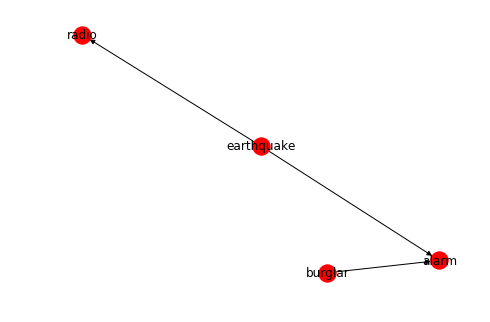

In [7]:
dag_wrapper = DAG(var_names, pot=pot)

dag_wrapper.draw()

In [8]:
example_conditioning_vars = {"alarm": "yes", "radio": "yes"}
example_condpot = dag_wrapper.get_conditioned_pot(
    example_conditioning_vars, "burglar")
print_conditioned_pot(example_conditioning_vars, "burglar", example_condpot)

('current divided newpot.variables=', (array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)))
('current divided table: \n', array([[0.01009899],
       [0.98990101]]))
p(burglar|alarm=yes, radio=yes):
('p(burglar=yes|alarm=yes, radio=yes):', 0.0101)
('p(burglar=no|alarm=yes, radio=yes):', 0.9899)


In [9]:
example_conditioning_vars = {"alarm": "yes", "earthquake": "yes"}
example_condpot = dag_wrapper.get_conditioned_pot(
    example_conditioning_vars, "burglar")
print_conditioned_pot(example_conditioning_vars, "burglar", example_condpot)

('current divided newpot.variables=', (array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)))
('current divided table: \n', array([[0.01009899],
       [0.98990101]]))
p(burglar|alarm=yes, earthquake=yes):
('p(burglar=yes|alarm=yes, earthquake=yes):', 0.0101)
('p(burglar=no|alarm=yes, earthquake=yes):', 0.9899)


In [10]:
## WTF? Why does earthquake=no make burglary less probable?

In [9]:
example_conditioning_vars = {"alarm": "yes", "earthquake": "no"}
example_condpot = dag_wrapper.get_conditioned_pot(
    example_conditioning_vars, "burglar")
print_conditioned_pot(example_conditioning_vars, "burglar", example_condpot)

('current divided newpot.variables=', (array([], dtype=float64), array([], dtype=float64), array([], dtype=float64)))
('current divided table: \n', array([[1.00999899e-04],
       [9.99899000e-01]]))
p(burglar|alarm=yes, earthquake=no):
('p(burglar=yes|alarm=yes, earthquake=no):', 0.0001)
('p(burglar=no|alarm=yes, earthquake=no):', 0.9999)
